In [ ]:
# Download Datasets

!curl -O "https://crisisnlp.qcri.org/data/ASONAM17_damage_images/ASONAM17_Damage_Image_Dataset.tar.gz"
!tar -xvf ASONAM17_Damage_Image_Dataset.tar.gz
!rm ASONAM17_Damage_Image_Dataset.tar.gz
!mv ASONAM17_Damage_Image_Dataset Datasets

Streaming output truncated to the last 5000 lines.
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_none_im_41235.jpg
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_none_im_10419.jpg
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_none_im_41730.jpg
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_none_im_24444.jpg
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_severe_im_37253.jpg
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_none_im_10730.jpg
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_none_im_33389.jpg
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_severe_im_31342.jpg
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_severe_im_7402.jpg
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_severe_im_18835.jpg
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_mild_im_19357.jpg
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_severe_im_12162.jpg
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_none_im_10493.jpg
ASONAM17_Damage_Image_Dataset/nepal_eq/nepal_eq_severe_im_6125.png
ASONAM17_Damage

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import shutil

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
# !mkdir Datasets
# !mkdir Datasets/matthew_hurricane
!mkdir data

# Preparing Dataset



##### Copy datasets to respective folders so that the dataloader can correctly find the required datasets for training, validation and testing

In [ ]:
def prepare_dataset(dataset_name):
  def copy_files(file_name, dataset_name):
    # Copy Datasets to respective folders
    if file_name.endswith("train"):
      sub_folder = "train"
    elif file_name.endswith("dev"):
      sub_folder = "val"
    elif file_name.endswith("test"):
      sub_folder = "test"
    
    with open(os.path.join("Datasets", file_name), 'r') as fp:
      for record in fp.readlines():
        file, severity = record.strip().split()
        file = file.split('/')[-1]
        
        if not os.path.exists("Datasets/"+dataset_name+"/"+file):
          continue

        if int(severity) == 1 or int(severity) == 2:
          shutil.copy(os.path.join("Datasets", dataset_name, file), os.path.join(dataset_path, sub_folder, "damage"))
        elif int(severity) == 0:
          shutil.copy(os.path.join("Datasets", dataset_name, file), os.path.join(dataset_path, sub_folder, "nodamage"))

  filename = dataset_name.split("_")[0]
  base_ds_path = os.path.join("Datasets", dataset_name)
  dataset_path = os.path.join("data", dataset_name)

  train_filename = filename + ".train"
  val_filename = filename + ".dev"
  test_filename = filename + ".test"
  
  if not os.path.exists(dataset_path):
    os.mkdir(dataset_path)
    os.mkdir(os.path.join(dataset_path, "train"))
    os.mkdir(os.path.join(dataset_path, "train", "damage"))
    os.mkdir(os.path.join(dataset_path, "train", "nodamage"))

    os.mkdir(os.path.join(dataset_path, "val"))
    os.mkdir(os.path.join(dataset_path, "val", "damage"))
    os.mkdir(os.path.join(dataset_path, "val", "nodamage"))

    os.mkdir(os.path.join(dataset_path, "test"))
    os.mkdir(os.path.join(dataset_path, "test", "damage"))
    os.mkdir(os.path.join(dataset_path, "test", "nodamage"))

    copy_files(train_filename, dataset_name)
    copy_files(val_filename, dataset_name)
    copy_files(test_filename, dataset_name)



In [ ]:
all_datasets = ["nepal_eq", "ecuador_eq", "ruby_typhoon", "matthew_hurricane"]
for ds in all_datasets:
  prepare_dataset(ds)

### Transforming data and creating dataloaders

In [ ]:
# Data augmentation and normalization for training
def gen_dataloader(input_size, data_dir, batch_size):
  data_transforms = {
      'train': transforms.Compose([
          transforms.RandomResizedCrop(input_size),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
      'val': transforms.Compose([
          transforms.Resize(input_size),
          transforms.CenterCrop(input_size),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),

      'test': transforms.Compose([
          transforms.Resize(input_size),
          transforms.CenterCrop(input_size),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
  }

  # Create training and validation datasets
  image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
  # Create training and validation dataloaders
  dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

  return dataloaders_dict


# Defining functions for Training and Evaluating the models

### Train Model

This method trains the given model. It also prints the training loss and validation loss along with option to either plot or not plot the model's loss and accuracy on training and validation datasets

In [ ]:
def train_model(model, model_name, dataloaders, criterion, optimizer, num_epochs=25, plot_model=True):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    epochs_list = []

    train_loss_list = []
    val_loss_list = []

    train_acc_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        if (epoch % 5 == 0) or (epoch == num_epochs - 1):
          print()
          print('Epoch {}/{}'.format(epoch, num_epochs - 1))
          print('-' * 10)
        # Each epoch has a training and validation phase
        epochs_list.append(epoch)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            if phase == 'train':
              train_loss_list.append(epoch_loss)
              train_acc_list.append(epoch_acc)
            elif phase == 'val':
              val_loss_list.append(epoch_loss)
              val_acc_list.append(epoch_acc)
            if (epoch % 5 == 0) or (epoch == num_epochs - 1):
              print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
          

    time_elapsed = time.time() - since
    print()
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    torch.cuda.empty_cache()

    if plot_model == True:
      plot_model_training(epochs_list, train_loss_list, val_loss_list, train_acc_list, val_acc_list, model_name)

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

### Initialize model for training

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    if model_name == "vgg":
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft


In [ ]:
# Helper function to plot the loss/accuracy graph for train/val datasets
def plot_model_training(epochs_list, train_loss_list, val_loss_list, train_acc_list, val_acc_list, model_name):
  # Training/Validation Loss
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.plot(epochs_list, train_loss_list, label="Training Loss")
  plt.plot(epochs_list, val_loss_list, label="Validation Loss")
  plt.legend()
  plt.savefig(model_name + "_loss.jpg")
  plt.show()
  plt.clf()
  plt.cla()
  plt.close()
  
  # Training/Validation Accuracy
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.plot(epochs_list, train_acc_list, label="Training Accuracy")
  plt.plot(epochs_list, val_acc_list, label="Validation Accuracy")
  plt.legend()
  plt.savefig(model_name + "_acc.jpg")
  plt.show()
  plt.clf()
  plt.cla()
  plt.close()



In [ ]:
def evaluate_model(model, dataloaders, model_name):  
  # Iterate over data.
  tp, fp, tn, fn = [0, 0, 0, 0]
  for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

    predictions = preds.tolist()
    ground_truth = labels.data.tolist()

    # statistics
    for p, t in zip(predictions, ground_truth):
      if (p == 1) and (t == 1):
        tp += 1
      elif (p == 0) and (t == 1):
        fn += 1
      elif (p == 1) and (t == 0):
        fp += 1
      elif (p == 0) and (t == 0):
        tn += 1

  # Print the model performance
  print("*" * 10 + "MODEL: " + model_name + " " + "*" * 10)
  print("accuracy: ", round((tp + tn) / (tp + fp + fn + tn), 3))
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  print("precision: ", round(precision, 3))
  print("recall: ", round(recall, 3))
  print("f1-score: ", round(2 * recall * precision / (recall + precision), 3))
  print("*" * 30)

In [ ]:
def get_parms_to_optimize(model_ft):
  # Send the model to GPU
  model_ft = model_ft.to(device)
  params_to_update = model_ft.parameters()
  print("Params to learn:")
  if feature_extract:
      params_to_update = []
      for name,param in model_ft.named_parameters():
          if param.requires_grad == True:
              params_to_update.append(param)
              print("\t",name)
  else:
      for name,param in model_ft.named_parameters():
          if param.requires_grad == True:
              print("\t",name)

  return optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Experimentation with Models for Different Datasets

In [ ]:
# Parameters that are same for all models
num_classes = 2
batch_size = 16
num_epochs = 10
model_name = "vgg"
input_size = 224 # Size of input image for VGG 

# Setup the loss function
criterion = nn.CrossEntropyLoss()

### Matthew Hurricane

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
data_dir = "./data/matthew_hurricane"

Params to learn:
	 classifier.6.weight
	 classifier.6.bias

Epoch 0/9
----------
train Loss: 0.6854 Acc: 0.5882
val Loss: 0.5106 Acc: 0.7750

Epoch 5/9
----------
train Loss: 0.4522 Acc: 0.7787
val Loss: 0.4501 Acc: 0.7583

Epoch 9/9
----------
train Loss: 0.4164 Acc: 0.7871
val Loss: 0.4275 Acc: 0.7917

Training complete in 1m 15s
Best val Acc: 0.791667


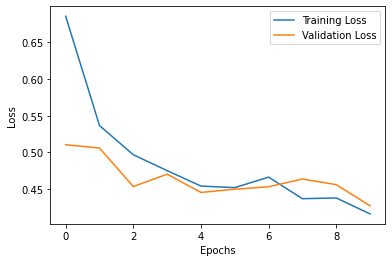

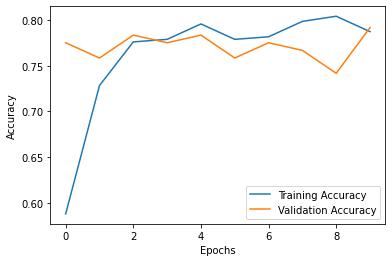

In [ ]:
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Initialize the model for this run
model_ft = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
dataloaders_dict = gen_dataloader(input_size, data_dir, batch_size)
optimizer_ft = get_parms_to_optimize(model_ft)
# Train and evaluate

model_matthew_last = train_model(model_ft, "matthew_last", dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.4.weight
	 features.4.bias
	 features.5.weight
	 features.5.bias
	 features.8.weight
	 features.8.bias
	 features.9.weight
	 features.9.bias
	 features.11.weight
	 features.11.bias
	 features.12.weight
	 features.12.bias
	 features.15.weight
	 features.15.bias
	 features.16.weight
	 features.16.bias
	 features.18.weight
	 features.18.bias
	 features.19.weight
	 features.19.bias
	 features.22.weight
	 features.22.bias
	 features.23.weight
	 features.23.bias
	 features.25.weight
	 features.25.bias
	 features.26.weight
	 features.26.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias

Epoch 0/9
----------
train Loss: 0.6589 Acc: 0.5938
val Loss: 0.5110 Acc: 0.7583

Epoch 5/9
----------
train Loss: 0.3769 Acc: 0.8431
val Loss: 0.4604 Acc: 0.7833

Epoch 9/9
----------
train Loss: 0.2277 Acc: 0.9160
val Loss: 0.

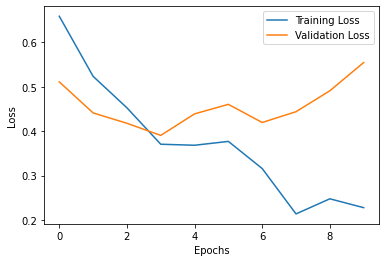

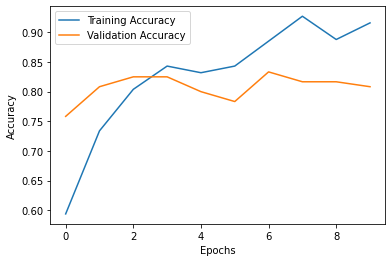

In [ ]:
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

# Initialize the model for this run
model_ft = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
dataloaders_dict = gen_dataloader(input_size, data_dir, batch_size)
optimizer_ft = get_parms_to_optimize(model_ft)
# Train and evaluate
model_matthew_all = train_model(model_ft, "matthew_all", dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

### Ruby Typhoon

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
data_dir = "./data/ruby_typhoon"

Params to learn:
	 classifier.6.weight
	 classifier.6.bias

Epoch 0/9
----------
train Loss: 0.6141 Acc: 0.6700
val Loss: 0.4261 Acc: 0.8084

Epoch 5/9
----------
train Loss: 0.3743 Acc: 0.8320
val Loss: 0.4481 Acc: 0.8204

Epoch 9/9
----------
train Loss: 0.3243 Acc: 0.8700
val Loss: 0.4261 Acc: 0.8323

Training complete in 1m 5s
Best val Acc: 0.838323


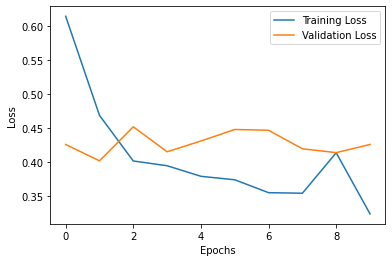

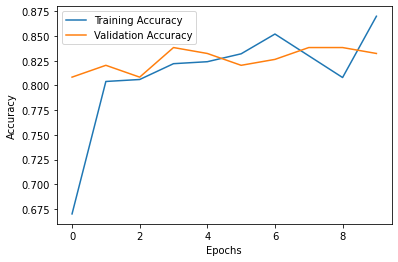

In [ ]:
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Initialize the model for this run
model_ft = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
dataloaders_dict = gen_dataloader(input_size, data_dir, batch_size)
optimizer_ft = get_parms_to_optimize(model_ft)
# Train and evaluate
model_ruby_last = train_model(model_ft, "ruby_last", dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.4.weight
	 features.4.bias
	 features.5.weight
	 features.5.bias
	 features.8.weight
	 features.8.bias
	 features.9.weight
	 features.9.bias
	 features.11.weight
	 features.11.bias
	 features.12.weight
	 features.12.bias
	 features.15.weight
	 features.15.bias
	 features.16.weight
	 features.16.bias
	 features.18.weight
	 features.18.bias
	 features.19.weight
	 features.19.bias
	 features.22.weight
	 features.22.bias
	 features.23.weight
	 features.23.bias
	 features.25.weight
	 features.25.bias
	 features.26.weight
	 features.26.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias

Epoch 0/9
----------
train Loss: 0.5950 Acc: 0.6780
val Loss: 0.4122 Acc: 0.8024

Epoch 5/9
----------
train Loss: 0.2477 Acc: 0.9020
val Loss: 0.4383 Acc: 0.8563

Epoch 9/9
----------
train Loss: 0.1665 Acc: 0.9300
val Loss: 0.

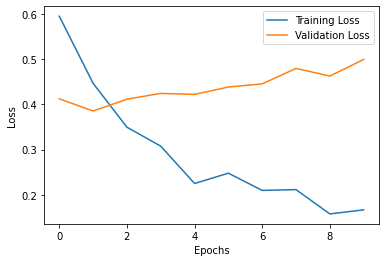

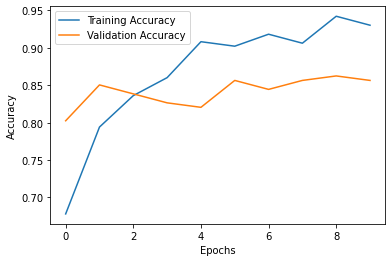

In [ ]:
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

# Initialize the model for this run
model_ft = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
dataloaders_dict = gen_dataloader(input_size, data_dir, batch_size)
optimizer_ft = get_parms_to_optimize(model_ft)
# Train and evaluate
model_ruby_all = train_model(model_ft, "ruby_all", dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

### Ecquador Earthquake

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
data_dir = "./data/ecuador_eq"

Params to learn:
	 classifier.6.weight
	 classifier.6.bias

Epoch 0/9
----------
train Loss: 0.3978 Acc: 0.8136
val Loss: 0.2713 Acc: 0.8860

Epoch 5/9
----------
train Loss: 0.2840 Acc: 0.8882
val Loss: 0.2384 Acc: 0.9079

Epoch 9/9
----------
train Loss: 0.3019 Acc: 0.8743
val Loss: 0.2280 Acc: 0.9211

Training complete in 3m 8s
Best val Acc: 0.927632


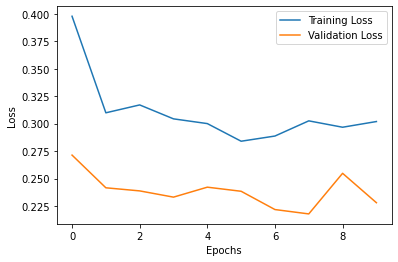

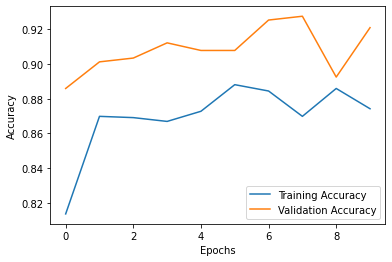

In [ ]:
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Initialize the model for this run
model_ft = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
dataloaders_dict = gen_dataloader(input_size, data_dir, batch_size)
optimizer_ft = get_parms_to_optimize(model_ft)
# Train and evaluate
model_ecquador_last = train_model(model_ft, "ecquador_last", dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.4.weight
	 features.4.bias
	 features.5.weight
	 features.5.bias
	 features.8.weight
	 features.8.bias
	 features.9.weight
	 features.9.bias
	 features.11.weight
	 features.11.bias
	 features.12.weight
	 features.12.bias
	 features.15.weight
	 features.15.bias
	 features.16.weight
	 features.16.bias
	 features.18.weight
	 features.18.bias
	 features.19.weight
	 features.19.bias
	 features.22.weight
	 features.22.bias
	 features.23.weight
	 features.23.bias
	 features.25.weight
	 features.25.bias
	 features.26.weight
	 features.26.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias

Epoch 0/9
----------
train Loss: 0.3845 Acc: 0.8304
val Loss: 0.2544 Acc: 0.9145

Epoch 5/9
----------
train Loss: 0.1940 Acc: 0.9218
val Loss: 0.2801 Acc: 0.9123

Epoch 9/9
----------
train Loss: 0.1572 Acc: 0.9481
val Loss: 0.

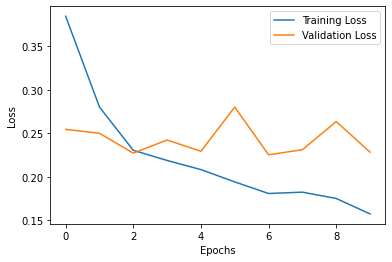

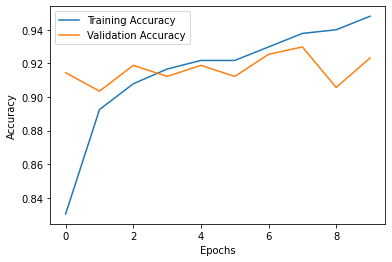

In [ ]:
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

# Initialize the model for this run
model_ft = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
dataloaders_dict = gen_dataloader(input_size, data_dir, batch_size)
optimizer_ft = get_parms_to_optimize(model_ft)
# Train and evaluate
model_ecquador_all = train_model(model_ft, "ecquador_all", dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

### Nepal Earthquake

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
data_dir = "./data/nepal_eq"

Params to learn:
	 classifier.6.weight
	 classifier.6.bias

Epoch 0/4
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4182 Acc: 0.8110
val Loss: 0.3153 Acc: 0.8636


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.w


Epoch 4/4
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.4008 Acc: 0.8236
val Loss: 0.3115 Acc: 0.8676

Training complete in 15m 14s
Best val Acc: 0.871761


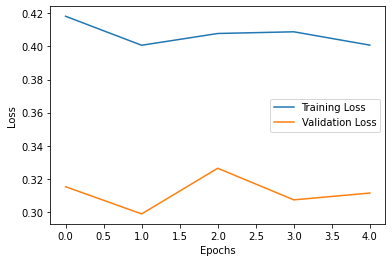

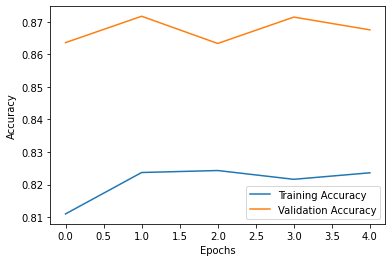

In [ ]:
num_epochs = 5
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Initialize the model for this run
model_ft = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
dataloaders_dict = gen_dataloader(input_size, data_dir, batch_size)
optimizer_ft = get_parms_to_optimize(model_ft)
# Train and evaluate
model_nepal_last = train_model(model_ft, "nepal_last", dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.4.weight
	 features.4.bias
	 features.5.weight
	 features.5.bias
	 features.8.weight
	 features.8.bias
	 features.9.weight
	 features.9.bias
	 features.11.weight
	 features.11.bias
	 features.12.weight
	 features.12.bias
	 features.15.weight
	 features.15.bias
	 features.16.weight
	 features.16.bias
	 features.18.weight
	 features.18.bias
	 features.19.weight
	 features.19.bias
	 features.22.weight
	 features.22.bias
	 features.23.weight
	 features.23.bias
	 features.25.weight
	 features.25.bias
	 features.26.weight
	 features.26.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias

Epoch 0/4
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.3751 Acc: 0.8383
val Loss: 0.2893 Acc: 0.8775


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.w


Epoch 4/4
----------


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


train Loss: 0.2693 Acc: 0.8882
val Loss: 0.2350 Acc: 0.9102

Training complete in 16m 17s
Best val Acc: 0.910233


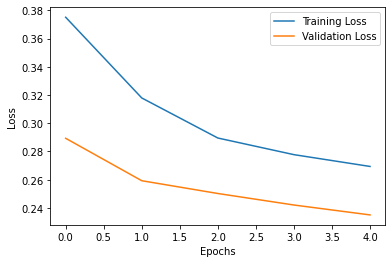

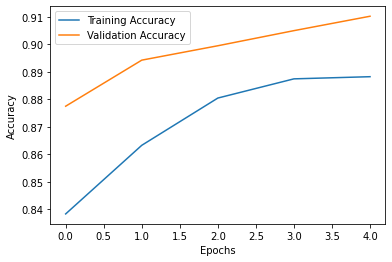

In [ ]:
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False
num_epochs = 5
# Initialize the model for this run
model_ft = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
dataloaders_dict = gen_dataloader(input_size, data_dir, batch_size)
optimizer_ft = get_parms_to_optimize(model_ft)
# Train and evaluate
model_nepal_all = train_model(model_ft, "nepal_all", dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

# Results in terms of Performance vs Data Size vs Number of Layers fine-tuned

In [ ]:
# Training datasets in each category
matthew = 357
ruby = 500
ecquador = 1368
nepal = 11463

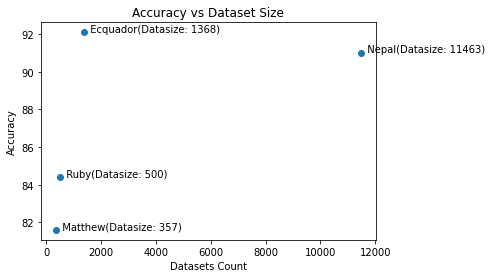

In [ ]:
txt = ["  Matthew", "  Ruby", "  Ecquador", "  Nepal"]
max_val_acc = [81.6, 84.4, 92.1, 91.02] # Arranged according to txt
y = max_val_acc
x = [matthew, ruby, ecquador, nepal]

plt.scatter(x, max_val_acc)
plt.ylabel("Accuracy")
plt.xlabel("Datasets Count")
plt.title("Accuracy vs Dataset Size")
i = 0
for x, y in zip(x, y):
  plt.annotate(txt[i] + "(Datasize: " + str(x) + ")", (x, y))
  i += 1

plt.savefig("acc_vs_datasize.jpg")
plt.show()

Accuracy vs Dataset Size:

Performance vs Number of layers fine-tuned:


# Evolution of Loss and Accuracy for both training and validation sets (for two comparatively good and bad model)

In [ ]:
num_epochs = 10

In [ ]:
## RELATIVELY BAD MODEL
# Top level data directory. Here we assume the format of the directory conforms
data_dir = "./data/matthew_hurricane"

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Initialize the model for this run
model_ft = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
dataloaders_dict = gen_dataloader(input_size, data_dir, batch_size)
optimizer_ft = get_parms_to_optimize(model_ft)
# Train and evaluate

model_matthew_all = train_model(model_ft, "matthew_all_bad", dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)


KeyboardInterrupt: ignored

In [ ]:
## RELATIVELY GOOD MODEL
# Top level data directory. Here we assume the format of the directory conforms
data_dir = "./data/ecuador_eq"

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

# Initialize the model for this run
model_ft = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
dataloaders_dict = gen_dataloader(input_size, data_dir, batch_size)
optimizer_ft = get_parms_to_optimize(model_ft)
# Train and evaluate
model_ecquador_all = train_model(model_ft, "ecquador_all_good", dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)


# Evaluation of Models

Use of Best models to evaluate on the test dataset

#### Matthew Hurricane

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
data_dir = "./data/matthew_hurricane"

# Initialize the model for this run
dataloaders_dict = gen_dataloader(input_size, data_dir, batch_size)
evaluate_model(model_matthew_all, dataloaders_dict, "matthew_hurricane_all")


**********MODEL: matthew_hurricane_all **********
accuracy:  0.773
precision:  0.771
recall:  0.831
f1-score:  0.8
******************************


#### Ruby Typhoon

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
data_dir = "./data/ruby_typhoon"

# Initialize the model for this run
dataloaders_dict = gen_dataloader(input_size, data_dir, batch_size)
evaluate_model(model_ruby_all, dataloaders_dict, "ruby_typhoon_all")


**********MODEL: ruby_typhoon_all **********
accuracy:  0.855
precision:  0.804
recall:  0.925
f1-score:  0.86
******************************


#### Ecquador Earthquake

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
data_dir = "./data/ecuador_eq"

# Initialize the model for this run
dataloaders_dict = gen_dataloader(input_size, data_dir, batch_size)
evaluate_model(model_ecquador_all, dataloaders_dict, "ecquador_earthquake_all")


**********MODEL: ecquador_earthquake_all **********
accuracy:  0.928
precision:  0.903
recall:  0.918
f1-score:  0.91
******************************


#### Nepal Earthquake

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
data_dir = "./data/nepal_eq"

# Initialize the model for this run
dataloaders_dict = gen_dataloader(input_size, data_dir, batch_size)
evaluate_model(model_nepal_all, dataloaders_dict, "nepal_earthquake_all")


**********MODEL: nepal_earthquake_all **********
accuracy:  0.903
precision:  0.859
recall:  0.918
f1-score:  0.887
******************************
